# Ad Ease website Analytics

### Dataset: Web Traffic Time Series Forecasting

* Forecasting the future values of multiple time series. More specifically the problem of forecasting future web traffic for approximately 145,000 articles on britanica.

* The training dataset consists of approximately 145k time series. Each of these time series represent a number of daily views of a different article, starting from July, 1st, 2015 up until December 31st, 2016. For each time series, you are provided the name of the article as well as the type of traffic that this time series represent (all, mobile, desktop, spider). You may use this metadata and any other publicly available data to make predictions. Unfortunately, the data source for this dataset does not distinguish between traffic values of zero and missing values. A missing value may mean the traffic was zero or that the data is not available for that day.

### Data Dictionary:

 *train_1.csv : *

* In the csv file, each row corresponds to a particular article and each column correspond to a particular date. The values are the number of visits in that date.

*Exog_Campaign_eng : *

* This file contaings data for the dates which had a campaign or significant event that could affect the views for that day. the data is just for pages in english.

* There is a 1 for dates with campaign and 0 for remaining dates. It is to be treated as an exogenous variable for models when training and forecasting data for pages in english

In [1]:
import pandas as pd
import numpy as np
import pylab as p
import matplotlib.pyplot as plot
from collections import Counter
import re
import os
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [3]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [4]:
train = pd.read_csv('new_train.csv')

In [5]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.britanica.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.britanica.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.britanica.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.britanica.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.britanica.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [6]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB
None


### Here we are plotting the data to check the null values. 

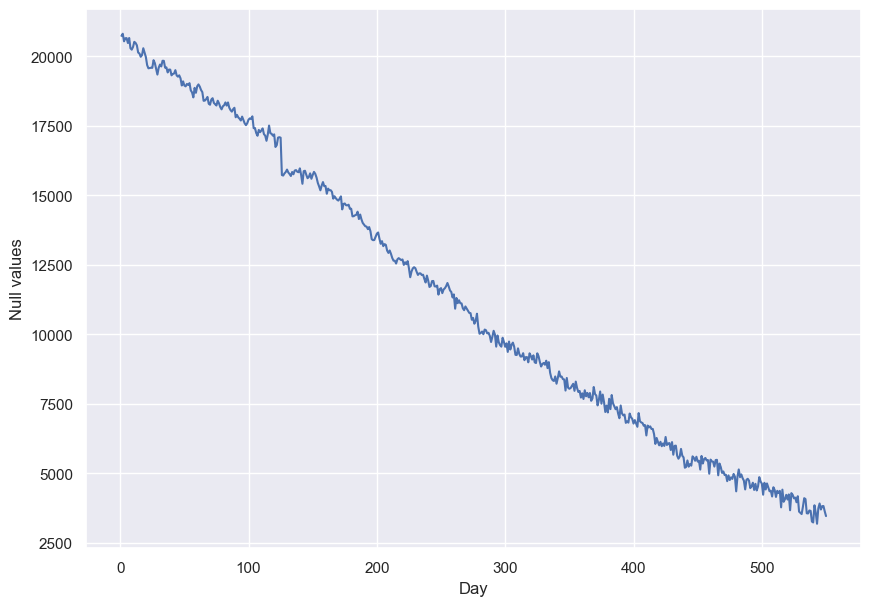

In [7]:
days = [r for r in range(1, len(train.columns))]
plot.figure(figsize=(10,7))
plot.xlabel('Day')
plot.ylabel('Null values')
plot.plot(days, train.isnull().sum()[1:])

* We see that the number of nan values decrease with time.

* Probable reason: Some website have all nan values in the begining, that can be due to the fact that those were created after that time so there is no traffic reading for that time

In [8]:
print(train.shape)
train=train.dropna(how='all')
print(train.shape)

train=train.dropna(thresh=300)
print(train.shape)

(145063, 551)
(145063, 551)
(133617, 551)


* We try droping the rows that have all values as nan, none in our case.

* We then also drop rows that have nan more than 300 days, because the time series for that would not make much sense

* We fill all the remaining values with zero assuming there was no traffic on the date that the values are nan for.

In [9]:
train=train.fillna(0)
train.tail()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
145012,Legión_(Marvel_Comics)_es.britanica.org_all-ac...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,3.0,2.0,4.0,2.0,4.0,4.0,1.0,2.0,2.0
145013,Referéndum_sobre_la_permanencia_del_Reino_Unid...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,16.0,8.0,3.0,6.0,3.0,3.0,10.0,11.0,3.0
145014,Salida_del_Reino_Unido_de_la_Unión_Europea_es....,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.0,36.0,23.0,182.0,43.0,8.0,22.0,13.0,18.0,14.0
145015,"Amar,_después_de_amar_es.britanica.org_all-acc...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,30.0,27.0,14.0,8.0,7.0,5.0,43.0,12.0,25.0
145016,Anexo:89.º_Premios_Óscar_es.britanica.org_all-...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


* The page values are in this format

**SPECIFIC NAME _ LANGUAGE.britanica.org _ ACCESS TYPE _ ACCESS ORIGIN**

* having information about page name, the main domain, device type used to access the page, and also the request origin(spider or browser agent)

In [10]:
#Usage of Regex
def split_page(page):
    w = re.split('_|\.', page)
    print(w)
    return ' '.join(w[:-5]), w[-5], w[-2], w[-1]

split_page('2NE1_zh.britanica.org_all-access_spider')

['2NE1', 'zh', 'britanica', 'org', 'all-access', 'spider']


('2NE1', 'zh', 'all-access', 'spider')

In [11]:
def split_page(page):
  w = re.split('_|\.', page)
  return ' '.join(w[:-5]), w[-5], w[-2], w[-1]

li = list(train.Page.apply(lambda x: split_page(str(x))))
df = pd.DataFrame(li)
df.columns = ['Title', 'Language', 'Access_type','Access_origin']
df = pd.concat([train, df], axis = 1)

We split the page name and get that information joining it with a temporary database. below we get some rows to see the structure of the data

In [12]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Title,Language,Access_type,Access_origin
0,2NE1_zh.britanica.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,14.0,20.0,22.0,19.0,18.0,20.0,2NE1,zh,all-access,spider
1,2PM_zh.britanica.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,9.0,30.0,52.0,45.0,26.0,20.0,2PM,zh,all-access,spider
2,3C_zh.britanica.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,4.0,4.0,6.0,3.0,4.0,17.0,3C,zh,all-access,spider
3,4minute_zh.britanica.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,16.0,11.0,17.0,19.0,10.0,11.0,4minute,zh,all-access,spider
5,5566_zh.britanica.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,32.0,19.0,23.0,17.0,17.0,50.0,A'N'D,zh,all-access,spider


<Axes: xlabel='count', ylabel='Language'>

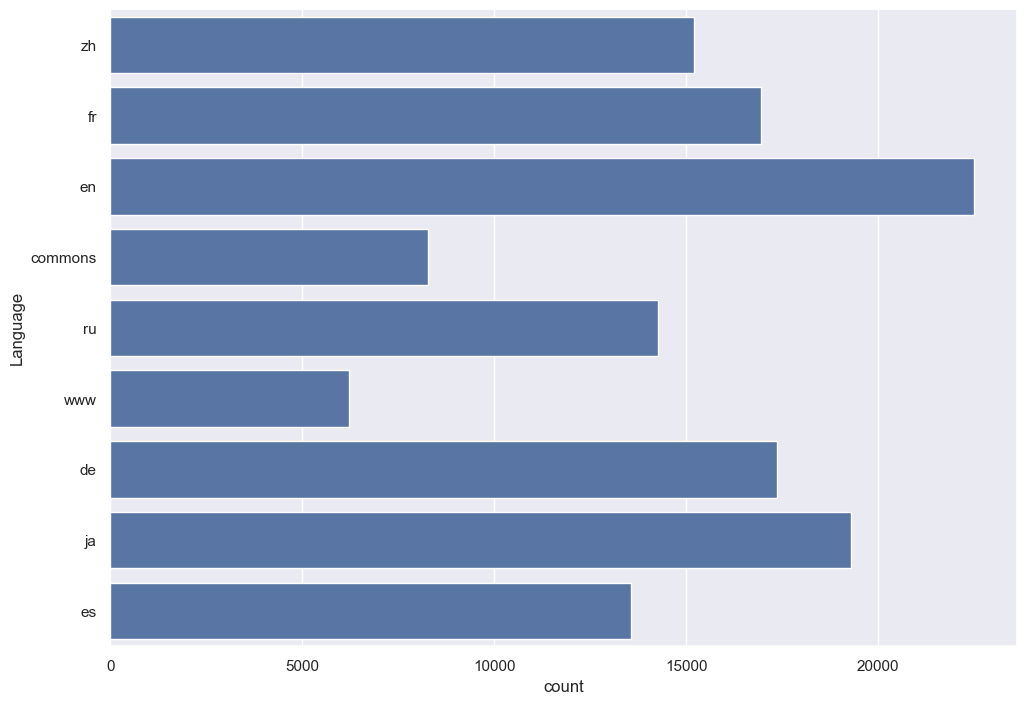

In [13]:
sns.countplot(df['Language'])

* This above is the comparision number of articles in each language

* {'ja':'Japanese', 'de':'German', 'en' : 'English', 'no_lang':'Media_File', 'fr':'French', 'zh':'Chinese', 'ru':'Russian', 'es':'Spanish'}

<Axes: xlabel='count', ylabel='Access_type'>

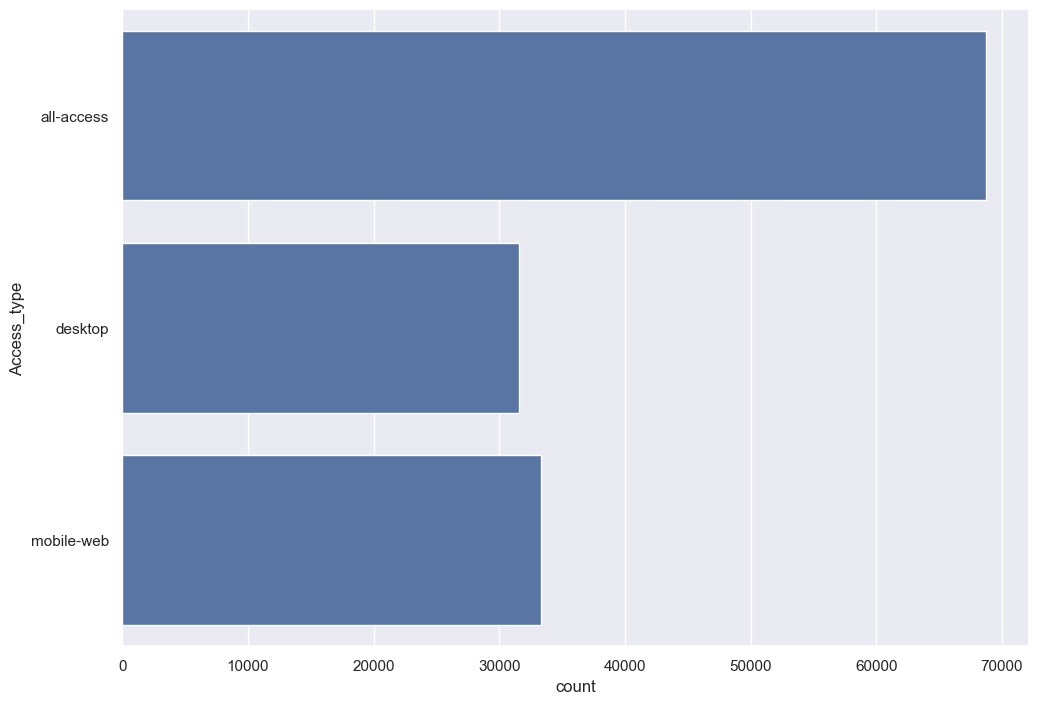

In [14]:
sns.countplot(df['Access_type'])

<Axes: xlabel='count', ylabel='Access_origin'>

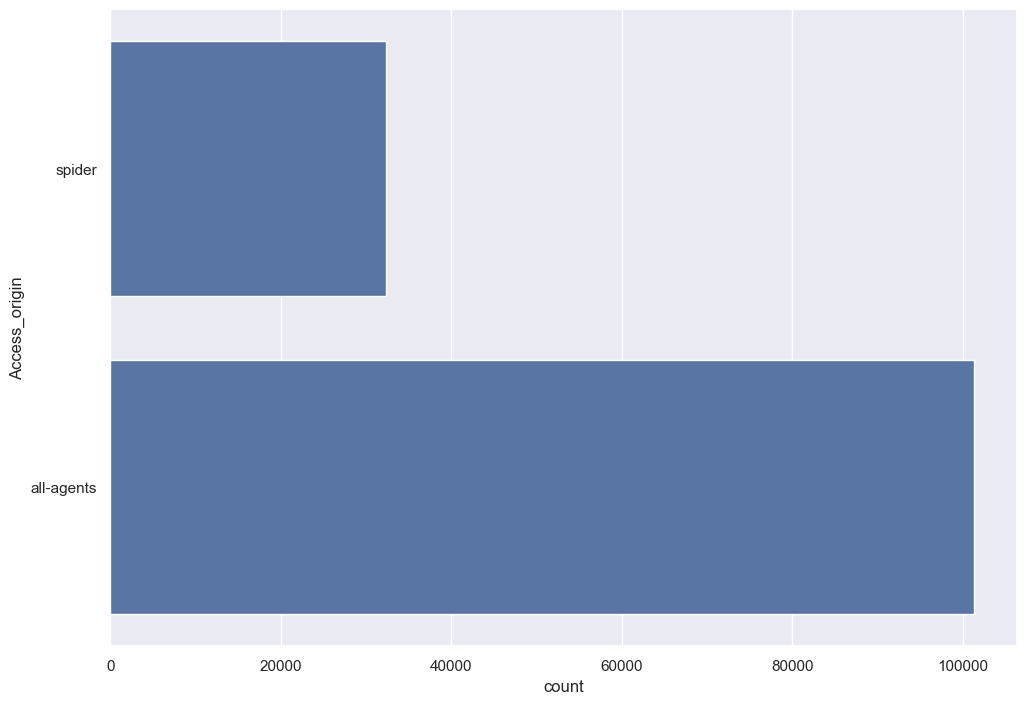

In [15]:
sns.countplot(df['Access_origin'])

This shows that organic view is far more than that of spiders or bots.

**Now we want to compare the views for different languages **

In [16]:
df.groupby('Language').count()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Title,Access_type,Access_origin
Language,,,,,,,,,,,,,,,,,,,,,
commons,7672,7672,7672,7672,7672,7672,7672,7672,7672,7672,...,7672,7672,7672,7672,7672,7672,7672,8266,8266,8266
de,15946,15946,15946,15946,15946,15946,15946,15946,15946,15946,...,15946,15946,15946,15946,15946,15946,15946,17362,17362,17362
en,20758,20758,20758,20758,20758,20758,20758,20758,20758,20758,...,20758,20758,20758,20758,20758,20758,20758,22486,22486,22486
es,12268,12268,12268,12268,12268,12268,12268,12268,12268,12268,...,12268,12268,12268,12268,12268,12268,12268,13551,13551,13551
fr,15418,15418,15418,15418,15418,15418,15418,15418,15418,15418,...,15418,15418,15418,15418,15418,15418,15418,16948,16948,16948
ja,17132,17132,17132,17132,17132,17132,17132,17132,17132,17132,...,17132,17132,17132,17132,17132,17132,17132,19295,19295,19295
ru,12955,12955,12955,12955,12955,12955,12955,12955,12955,12955,...,12955,12955,12955,12955,12955,12955,12955,14270,14270,14270
www,5743,5743,5743,5743,5743,5743,5743,5743,5743,5743,...,5743,5743,5743,5743,5743,5743,5743,6228,6228,6228
zh,14845,14845,14845,14845,14845,14845,14845,14845,14845,14845,...,14845,14845,14845,14845,14845,14845,14845,15211,15211,15211


In [17]:
df[df['Language']=='commons']

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Title,Language,Access_type,Access_origin
12271,Burning_Man_en.britanica.org_desktop_all-agents,1693.0,1490.0,1186.0,1099.0,1051.0,1968.0,1874.0,1637.0,1842.0,...,940.0,2976.0,2447.0,1648.0,1282.0,956.0,Accueil,commons,all-access,spider
12272,Cali_Cartel_en.britanica.org_desktop_all-agents,348.0,363.0,214.0,252.0,257.0,320.0,340.0,345.0,432.0,...,1197.0,1449.0,1376.0,1350.0,1287.0,992.0,Atlas of Asia,commons,all-access,spider
12273,Call_of_Duty:_Modern_Warfare_2_en.britanica.or...,806.0,768.0,700.0,725.0,723.0,823.0,849.0,731.0,833.0,...,818.0,929.0,892.0,878.0,893.0,712.0,Atlas of Europe,commons,all-access,spider
12274,Calvin_Harris_en.britanica.org_desktop_all-agents,7114.0,5599.0,7685.0,15844.0,9390.0,7173.0,5499.0,6367.0,5630.0,...,1242.0,1409.0,1714.0,1604.0,1602.0,1300.0,Atlas of World War II,commons,all-access,spider
12275,Carl_Sagan_en.britanica.org_desktop_all-agents,1808.0,1759.0,1838.0,1631.0,1701.0,2230.0,2052.0,2065.0,2002.0,...,1425.0,1730.0,1858.0,1781.0,1718.0,1345.0,Atlas of colonialism,commons,all-access,spider
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,File:Zyworodka - Kalanchoe daigremontiana JPG,commons,desktop,all-agents
75150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Commons:Open proxy detection,commons,desktop,all-agents
75178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,File:Crabs (Pachygrapsus marmoratus) webm,commons,desktop,all-agents
75237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Басты бет,commons,desktop,all-agents


In [18]:
def lang(Page):
    val = re.search('[a-z][a-z].britanica.org',Page)
    if val:
        return val[0][0:2]

    return 'no_lang'

df['Language']=df['Page'].apply(lambda x: lang(str(x)))

In [19]:
df.groupby('Language').count()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Title,Access_type,Access_origin
Language,,,,,,,,,,,,,,,,,,,,,
de,17362,17362,17362,17362,17362,17362,17362,17362,17362,17362,...,17362,17362,17362,17362,17362,17362,17362,13046,13046,13046
en,22486,22486,22486,22486,22486,22486,22486,22486,22486,22486,...,22486,22486,22486,22486,22486,22486,22486,22486,22486,22486
es,13551,13551,13551,13551,13551,13551,13551,13551,13551,13551,...,13551,13551,13551,13551,13551,13551,13551,10142,10142,10142
fr,16948,16948,16948,16948,16948,16948,16948,16948,16948,16948,...,16948,16948,16948,16948,16948,16948,16948,16948,16948,16948
ja,19295,19295,19295,19295,19295,19295,19295,19295,19295,19295,...,19295,19295,19295,19295,19295,19295,19295,16140,16140,16140
no_lang,14494,14494,14494,14494,14494,14494,14494,14494,14494,14494,...,14494,14494,14494,14494,14494,14494,14494,25374,25374,25374
ru,14270,14270,14270,14270,14270,14270,14270,14270,14270,14270,...,14270,14270,14270,14270,14270,14270,14270,14270,14270,14270
zh,15211,15211,15211,15211,15211,15211,15211,15211,15211,15211,...,15211,15211,15211,15211,15211,15211,15211,15211,15211,15211


In [20]:
df_language=df.groupby('Language').mean(numeric_only=True).transpose()
df_language

Language,de,en,es,fr,ja,no_lang,ru,zh
2015-07-01,763.765926,3767.328604,1127.485204,499.092872,614.637160,102.733545,663.199229,272.498521
2015-07-02,753.362861,3755.158765,1077.485425,502.297852,705.813216,107.663447,674.677015,272.906778
2015-07-03,723.074415,3565.225696,990.895949,483.007553,637.451671,101.769629,625.329783,271.097167
2015-07-04,663.537323,3711.782932,930.303151,516.275785,800.897435,86.853871,588.171829,273.712379
2015-07-05,771.358657,3833.433025,1011.759575,506.871666,768.352319,96.254105,626.385354,291.977713
...,...,...,...,...,...,...,...,...
2016-12-27,1119.596936,6314.335275,1070.923400,840.590217,808.541436,155.270181,998.374071,363.066991
2016-12-28,1062.284069,6108.874144,1108.996753,783.585379,807.430163,178.561267,945.054730,369.049701
2016-12-29,1033.939062,6518.058525,1058.660320,763.209169,883.752786,150.873534,909.352207,340.526330
2016-12-30,981.786430,5401.792360,807.551177,710.502773,979.278777,156.049193,815.475123,342.745316


In [21]:
df_language.reset_index(inplace=True)
df_language.set_index('index', inplace=True)

Text(0, 0.5, 'Views per Page')

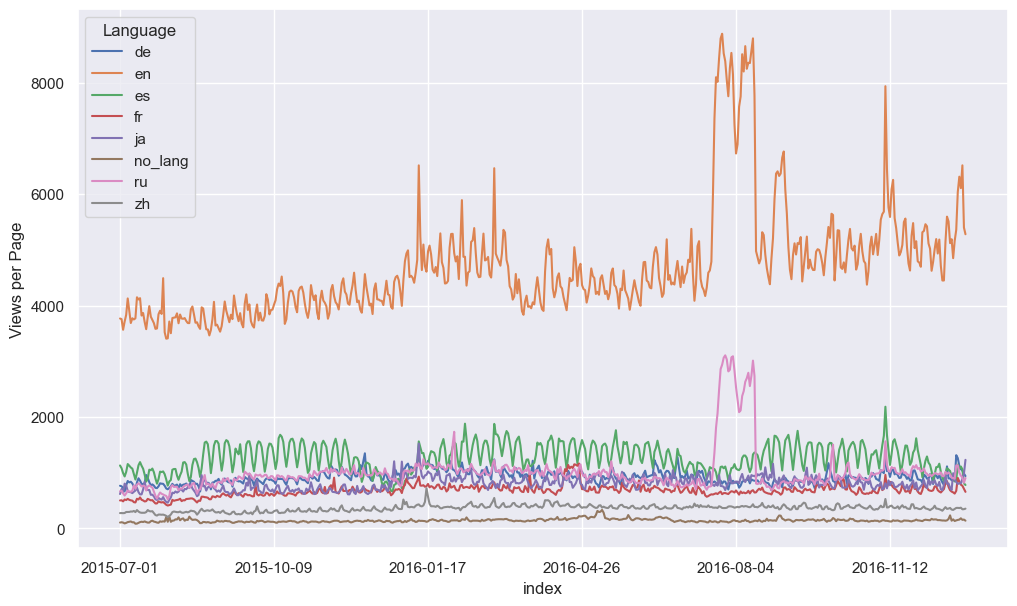

In [22]:
df_language.plot(figsize=(12,7))
plot.ylabel('Views per Page')

* Ploting the data shows that articles in english get the most number of views as compared to different languages, there are some spikes at different times in different laguages.

Text(0, 0.5, 'Views per Page')

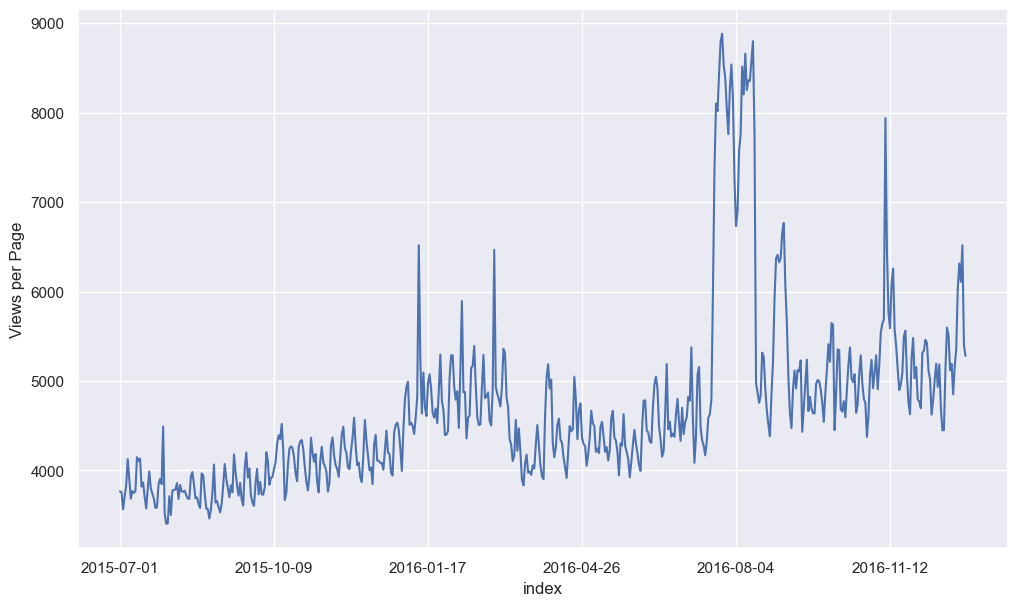

In [23]:
df_language['en'].plot(figsize=(12,7))
plot.ylabel('Views per Page')

In [24]:
total_view=df_language.copy()

## Checking the stationarity

**Dickey-Fuller test**

* Here the null hypothesis is that the TS is non-stationary: The test results comprise of a Test Statistic and some Critical Values for difference confidence levels.

In [25]:
from statsmodels.tsa.stattools import adfuller
def df_test(x):
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])

df_test(total_view['en'])

ADF Stastistic: -2.373563
p-value: 0.149337


* We see that the p value higher than <0.05. Therefore, we can say our series is not stationary as we fail to reject the null hypothesis

### Making the time series stationary

In [26]:
ts=total_view['en']

### 1. Remove trend and seasonality with decomposition

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts.values, model='multiplicative',period = 7)

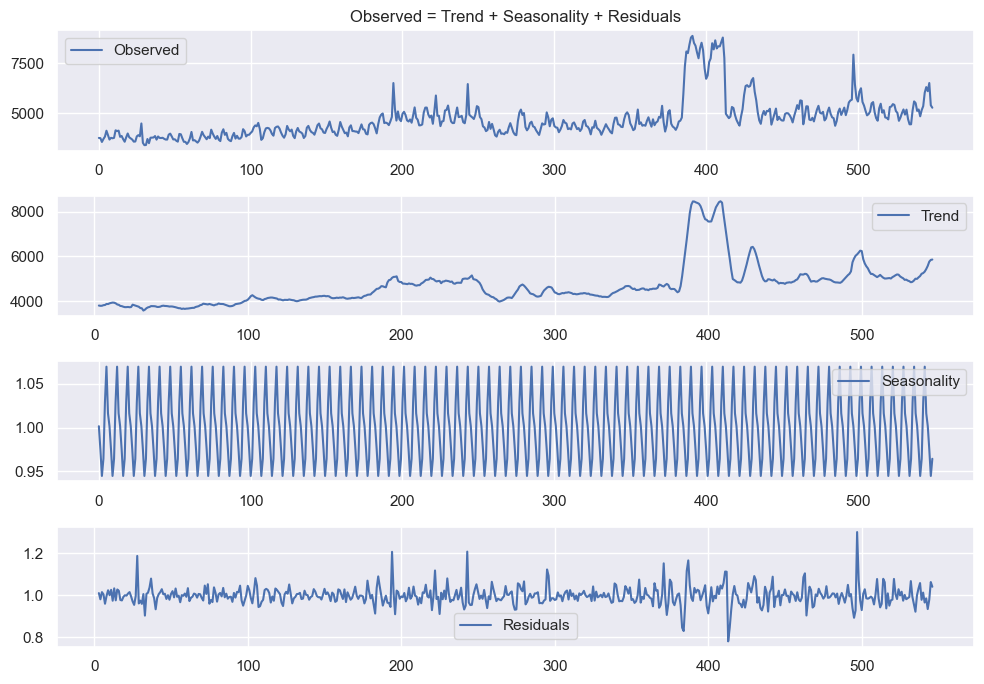

In [28]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plot.figure(figsize=(10,7))
plot.subplot(411)
plot.title('Observed = Trend + Seasonality + Residuals')
plot.plot(ts.values,label='Observed')
plot.legend(loc='best')
plot.subplot(412)
plot.plot(trend, label='Trend')
plot.legend(loc='best')
plot.subplot(413)
plot.plot(seasonal,label='Seasonality')
plot.legend(loc='best')
plot.subplot(414)
plot.plot(residual, label='Residuals')
plot.legend(loc='best')
plot.tight_layout()
plot.show()

In [29]:
ts_decompose=pd.DataFrame(residual).fillna(0)[0].values
df_test(ts_decompose)

ADF Stastistic: -3.796320
p-value: 0.002945


* We can see that aur series is now stationary, we can also try diffrencing to see what results we can get.

### 2. Remove trend and seasonality with differencing

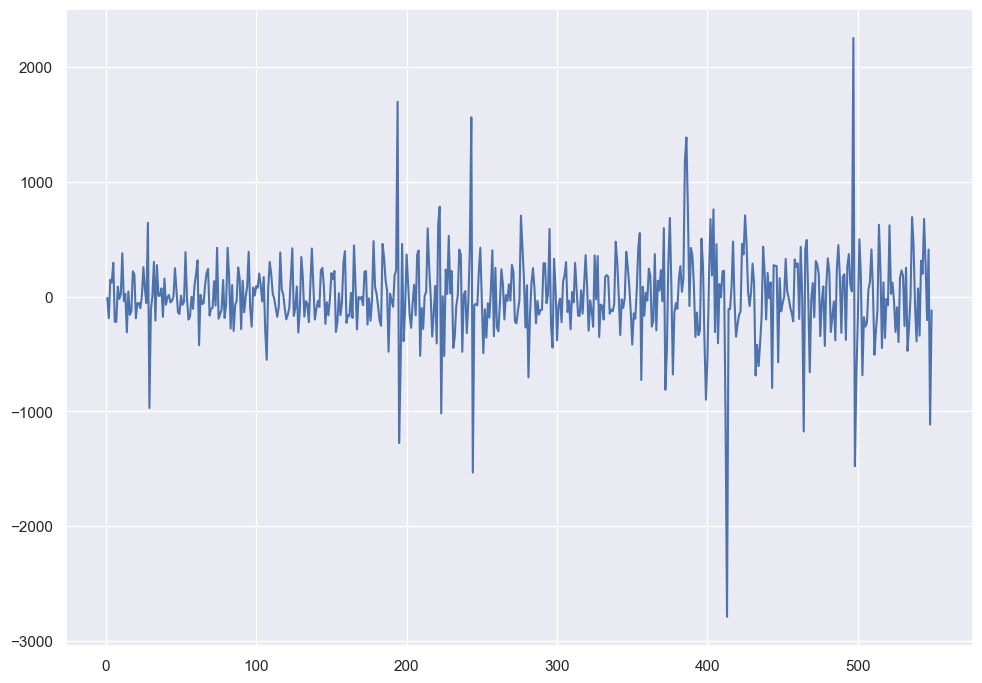

In [30]:
ts_diff = ts - ts.shift(1)
plot.plot(ts_diff.values)
plot.show()

In [31]:
ts_diff.dropna(inplace=True)
df_test(ts_diff)

ADF Stastistic: -8.273590
p-value: 0.000000


* Also the p value is 0. So we can say that our graph is now stationery. Now we can apply the ARIMA model.


### Plot the autocorreltaion and partial auto correlation functions

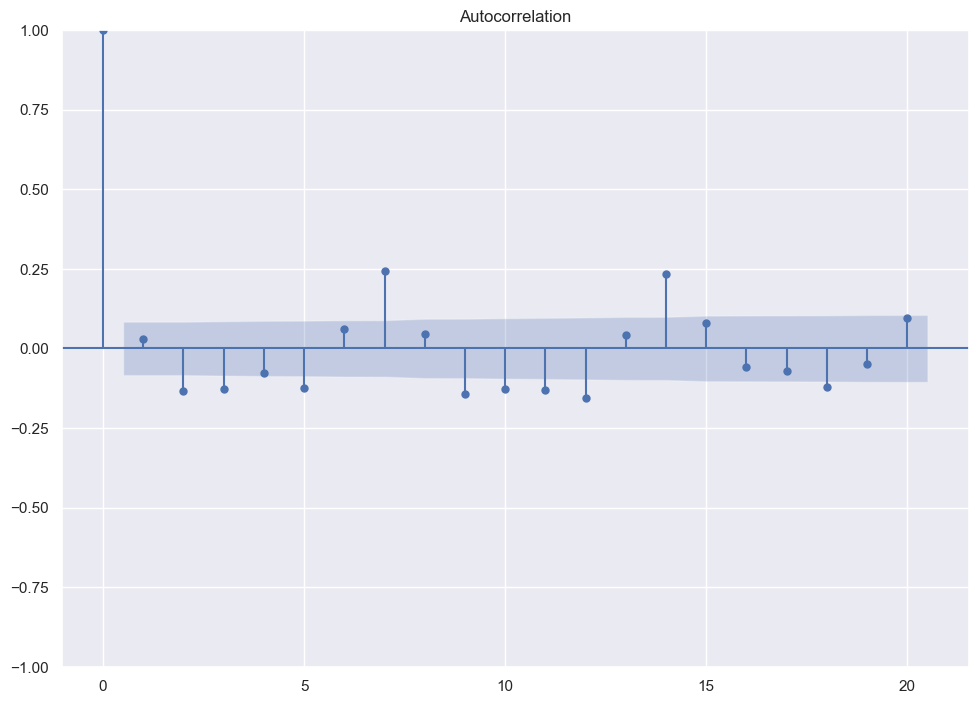

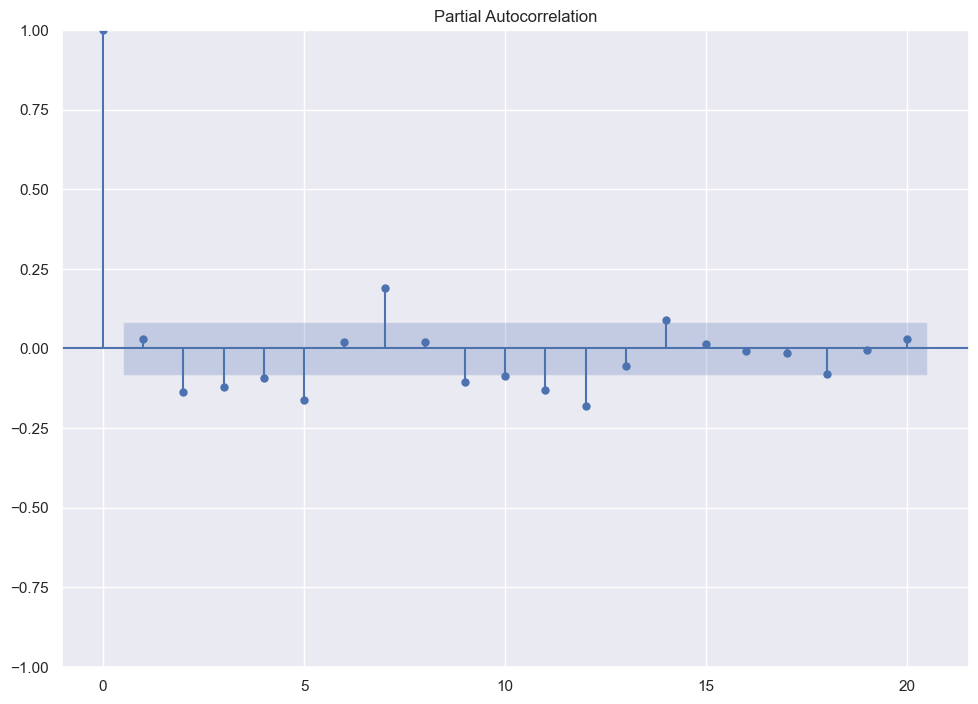

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf=plot_acf(ts_diff,lags=20)
pacf=plot_pacf(ts_diff,lags=20)

## ARIMA MODEL

In [33]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame

In [34]:
model = ARIMA(ts, order=(4, 1, 3))
model_fit = model.fit()

C:\Users\karan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\karan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\karan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### Multistep forecasting

In [35]:
train = ts[:-20]
test = ts[-20:]

C:\Users\karan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\karan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\karan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\karan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


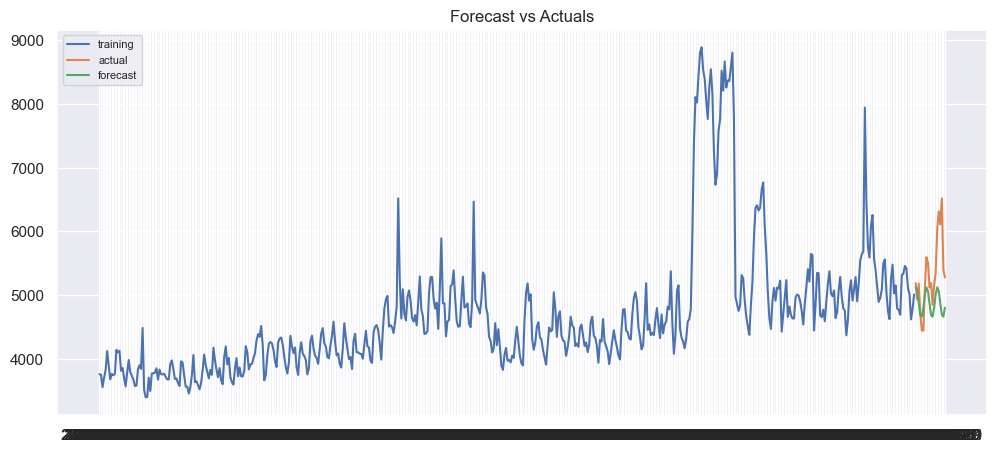

In [36]:
model = ARIMA(train, order=(4, 1, 3))
fitted = model.fit(method_kwargs={'disp': -1})

fc = fitted.forecast(20)
fc_series = pd.Series(fc, index=test.index)
forecast_obj = fitted.get_forecast(20)
conf_int = forecast_obj.conf_int(alpha=0.02)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
# Plot
plot.figure(figsize=(12,5), dpi=100)
plot.plot(train, label='training')
plot.plot(test, label='actual')
plot.plot(fc_series, label='forecast')

plot.title('Forecast vs Actuals')
plot.legend(loc='upper left', fontsize=8)

In [37]:
mape = np.mean(np.abs(fc - test.values)/np.abs(test.values))
rmse = np.mean((fc - test.values)**2)**.5
print("mape:",mape)
print("rsme:",rmse)

mape: 0.08968663360921941
rsme: 682.6240170130765


* We can see that the model does not perform very well for multistep out sample data

* From the decomposition we can see that there is a weekly seasonality and still some spikes in the residual, that may be because of some external factors, which we can take into account by using them as our exogenous variable

In [38]:
ex_df = pd.read_csv('Exog_Campaign_eng')
ex_df.head()

,Exog
0,0
1,0
2,0
3,0
4,0


* We get the exogenous data from this csv file for english pages.

In [39]:
exog=ex_df['Exog'].to_numpy()

* Now We are training a sarimax model to see if we get any improvements from using these two pieces of information.

* The seasonal order and the values of PDQ are based on various trials and comparisons of the models.

* We see a seasonality of 7 from the plots ie: weekly seasonality ( from the plots we can see that after some insignificant plots, we have some significant values repeating at intervals of 7 ie: 7,14 ... )

* The non seasonal order we can keep them as it is.

C:\Users\karan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\karan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\karan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


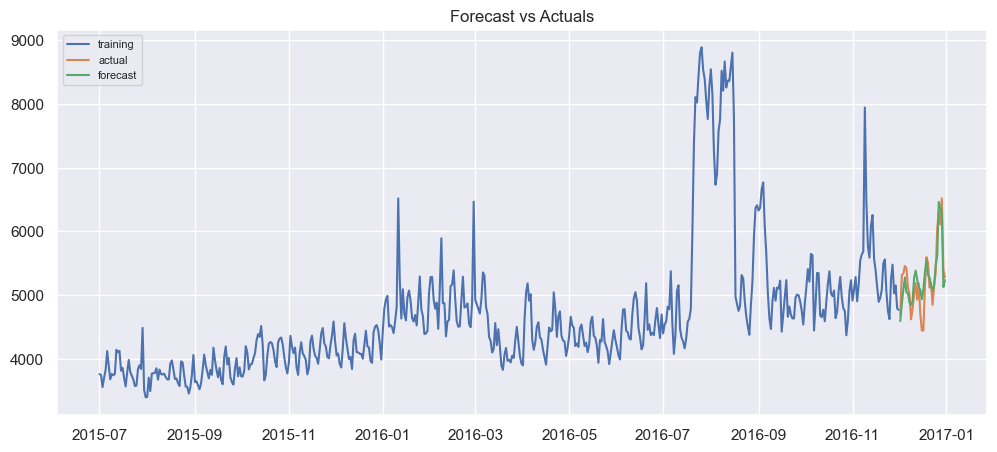

In [40]:
import statsmodels.api as sm
train=ts[:520]
test=ts[520:]
model=sm.tsa.statespace.SARIMAX(train,order=(4, 1, 3),seasonal_order=(1,1,1,7),exog=exog[:520])
results=model.fit()

fc=results.forecast(30,dynamic=True,exog=pd.DataFrame(exog[520:]))

# Make as pandas series
fc_series = pd.Series(fc)
# Plot
train.index=train.index.astype('datetime64[ns]')
test.index=test.index.astype('datetime64[ns]')
plot.figure(figsize=(12,5), dpi=100)
plot.plot(train, label='training')
plot.plot(test, label='actual')
plot.plot(fc_series, label='forecast')

plot.title('Forecast vs Actuals')
plot.legend(loc='upper left', fontsize=8)

In [41]:
mape = np.mean(np.abs(fc - test.values)/np.abs(test.values))
rmse = np.mean((fc - test.values)**2)**.5
print("mape:",mape)
print("rsme:",rmse)

mape: 0.043137007047603745
rsme: 266.1311691896771


## The mean absolute percentage error and the root mean squared error is improved.

In [42]:
ts_df=ts.to_frame()
ts_df.head()

,en
index,
2015-07-01,3767.328604
2015-07-02,3755.158765
2015-07-03,3565.225696
2015-07-04,3711.782932
2015-07-05,3833.433025


In [43]:
ts_df.reset_index(level=0, inplace=True)
ts_df['date']=pd.to_datetime(ts_df['index'])
ts_df.drop(['index'],axis=1,inplace=True)
ts_df.head()

,en,date
0,3767.328604,2015-07-01
1,3755.158765,2015-07-02
2,3565.225696,2015-07-03
3,3711.782932,2015-07-04
4,3833.433025,2015-07-05


In [44]:
ts_df['day_of_week']=ts_df['date'].dt.day_name()
ts_df.head()

,en,date,day_of_week
0,3767.328604,2015-07-01,Wednesday
1,3755.158765,2015-07-02,Thursday
2,3565.225696,2015-07-03,Friday
3,3711.782932,2015-07-04,Saturday
4,3833.433025,2015-07-05,Sunday


In [45]:
ts_df=pd.get_dummies(ts_df, columns = ['day_of_week'])

In [46]:
ts_df.head()

,en,date,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,3767.328604,2015-07-01,False,False,False,False,False,False,True
1,3755.158765,2015-07-02,False,False,False,False,True,False,False
2,3565.225696,2015-07-03,True,False,False,False,False,False,False
3,3711.782932,2015-07-04,False,False,True,False,False,False,False
4,3833.433025,2015-07-05,False,False,False,True,False,False,False


In [47]:
ts_df['exog']=ex_df['Exog']
ts_df['rolling_mean']=ts_df['en'].rolling(7).mean()

In [48]:
ts_df=ts_df.dropna()
ts_df.head()

,en,date,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,exog,rolling_mean
6,3906.341724,2015-07-07,False,False,False,False,False,True,False,0,3809.528545
7,3685.854621,2015-07-08,False,False,False,False,False,False,True,0,3797.889404
8,3771.183714,2015-07-09,False,False,False,False,True,False,False,0,3800.178683
9,3749.860313,2015-07-10,True,False,False,False,False,False,False,0,3826.555056
10,3770.749355,2015-07-11,False,False,True,False,False,False,False,0,3834.978831


## Now, We are tring Facebook Prophet

In [49]:
ts_df['ds']=ts_df['date']
ts_df['y']=ts_df['en']

In [50]:
df2=ts_df[['date','en','exog']].copy()
df2.columns = ['ds', 'y', 'exog']
df2.head()

,ds,y,exog
6,2015-07-07,3906.341724,0
7,2015-07-08,3685.854621,0
8,2015-07-09,3771.183714,0
9,2015-07-10,3749.860313,0
10,2015-07-11,3770.749355,0


In [51]:
df2[:-20].info()

<class 'pandas.core.frame.DataFrame'>
Index: 524 entries, 6 to 529
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      524 non-null    datetime64[ns]
 1   y       524 non-null    float64       
 2   exog    524 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 16.4 KB


### We are using prophet without exogenous

In [60]:
!pip install prophet

In [61]:
from prophet import Prophet

17:09:13 - cmdstanpy - INFO - Chain [1] start processing
17:09:19 - cmdstanpy - INFO - Chain [1] done processing


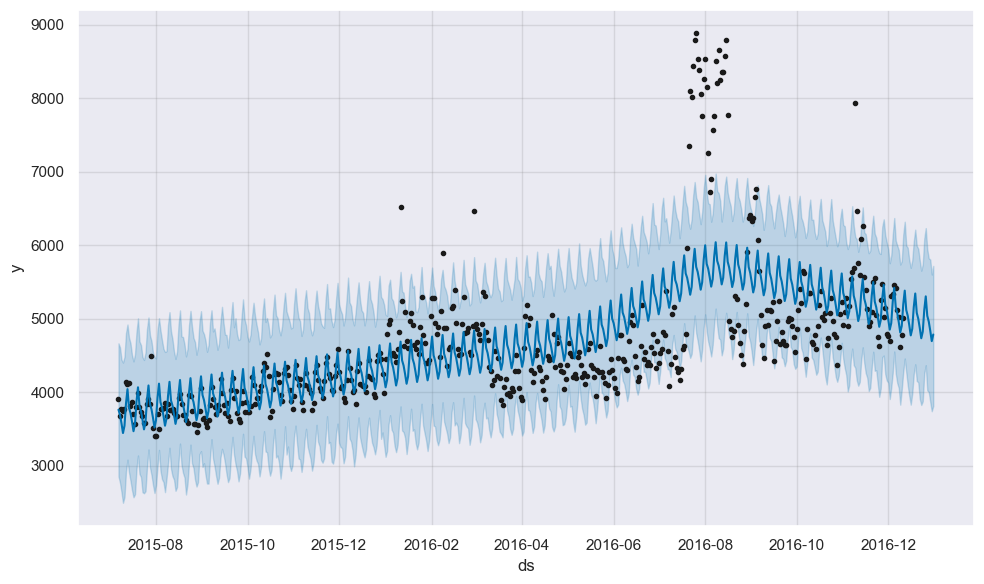

In [62]:
m = Prophet(weekly_seasonality=True)
m.fit(df2[['ds', 'y']][:-20])
future = m.make_future_dataframe(periods=20,freq="D")
forecast = m.predict(future)
fig = m.plot(forecast)

### prophet with exogenous

17:12:17 - cmdstanpy - INFO - Chain [1] start processing
17:12:17 - cmdstanpy - INFO - Chain [1] done processing


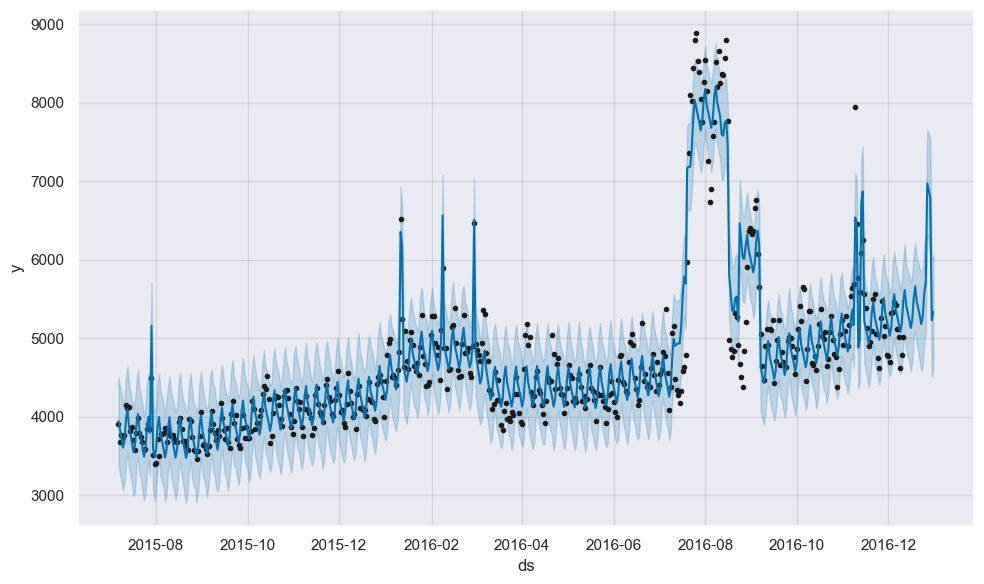

In [63]:
model2=Prophet(interval_width=0.9, weekly_seasonality=True, changepoint_prior_scale=1)
model2.add_regressor('exog')
model2.fit(df2[:-20])
forecast2 = model2.predict(df2)
fig = model2.plot(forecast2)

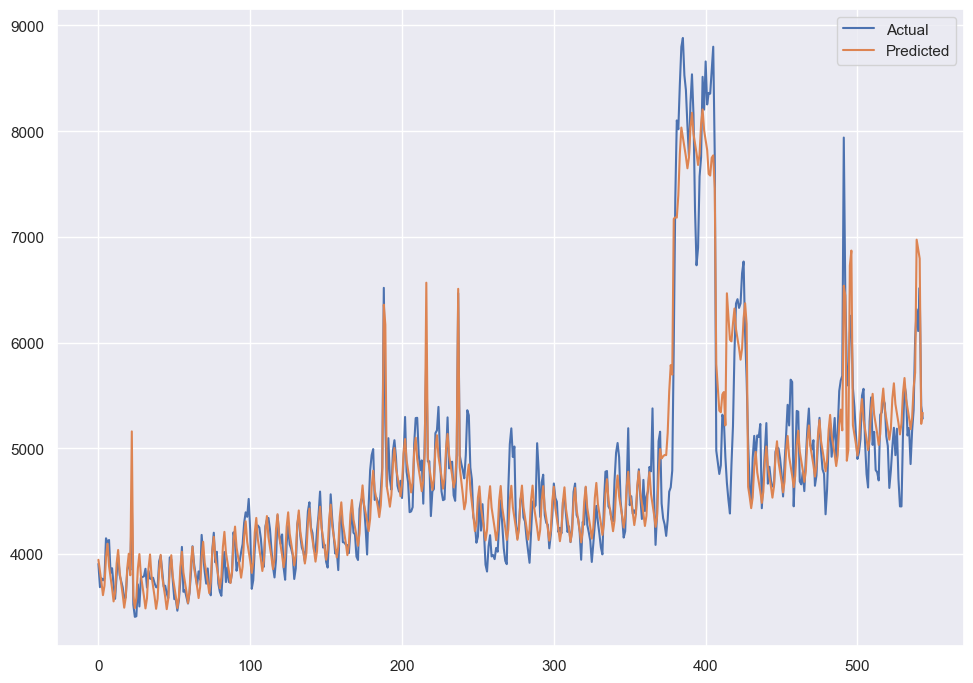

In [64]:
y_true = df2['y'].values
y_pred = forecast2['yhat'].values

plot.plot(y_true, label='Actual')
plot.plot(y_pred, label='Predicted')
plot.legend()
plot.show()

In [65]:
mape = np.mean(np.abs(forecast2['yhat'][-20:] - df2['y'][-20:].values)/np.abs(df2['y'][-20:].values))
print("mape:",mape)

mape: 0.06566497994510566


* Prophet does not perform well on non-stationary data because it is difficult to find the actual seasonality and trend of the data if the patterns are inconsistent.